# Interpolación Spline

Mario Valverde

Importamos nuestras librerías

In [7]:
import pandas as pd
import numpy as np
from sympy import symbols, init_printing, expand, lambdify
import matplotlib.pyplot as plt
from time import time
from random import randint

x = symbols('x')

Clase de Gauss para el método de Gauss-Jordan

In [8]:
class Gauss:

    def cambiarFilas(self, matriz, fila):
        cambio = 0
        for i in range(1, len(matriz) - fila):
            if matriz[fila + i][fila] != 0:
                cambio = i
                break
        
        if not cambio:
            return False
            
        fila1 = fila
        fila2 = fila + cambio

        temp = matriz[fila1].copy()
        matriz[fila1] = matriz[fila2]
        matriz[fila2] = temp
        return matriz

    def sumarFilas(self, matriz, fila):
        for i in range(1, len(matriz) -  fila):
            reduccion = matriz[fila][fila].copy()
            multiplo = -1*matriz[fila+i][fila].copy()
            matriz[fila + i] = matriz[fila+i] + matriz[fila] * multiplo / reduccion
        return matriz

    def checarCeros(self, matriz, fila):
        if matriz[fila][fila] == 0:
            return True
        return False

    def transformar(self, matriz):
        copia = matriz.copy()
        finalInv = matriz.copy()
        for i in range(0,len(matriz)):
            for j in range(0,len(matriz[0]) - 1):
                finalInv[i][j] = copia[i][-2-j]
        copia = finalInv.copy()
        for i in range(0,len(matriz)):
            finalInv[i] = copia[-1+-i]
        return finalInv

    def checarDim(self, matriz):
        filas = len(matriz)
        columnas = len(matriz[0])
        if filas < columnas - 1 or filas > columnas - 1:
            return False
        return True


    def Gauss(self, matriz):
        for fila in range(0,len(matriz)):
            if self.checarCeros(matriz, fila):
                matriz = self.cambiarFilas(matriz, fila)
                if not np.any(matriz):
                    return False
            self.sumarFilas(matriz, fila)
        return matriz



    def solucion(self, matriz):
        if not self.checarDim(matriz):
            print("La matriz no tiene solución")
            return False
        matriz = self.Gauss(matriz)
        if not np.any(matriz):
            print("La matriz no tiene solución")
            return False
        matriz = self.transformar(matriz)
        matriz = self.Gauss(matriz)
        matriz = self.transformar(matriz)
        return matriz

Clase NumMethods que contiene los métodos numéricos, particularmente el spline

In [9]:
class NumMethods:

    def __init__(self, Xs, Ys):
        self.puntosX = Xs
        self.puntosY = Ys
        self.matriz = []
        self.expr = 0

    def ordenar_puntos(self):
        desordenada = []
        for i in range(len(self.puntosX)):
            desordenada.append((self.puntosX[i], self.puntosY[i]))
        ordenada = []
        while desordenada:
            min = 0
            for i in range(len(desordenada)):
                if desordenada[i][0] < desordenada[min][0]:
                    min = i
            ordenada.append(desordenada.pop(min))
        self.puntosX = [x[0] for x in ordenada]
        self.puntosY = [y[1] for y in ordenada]

    def polinomios(self):
        matriz = self.matriz
        As = []
        Bs = []
        Cs = []
        for i in range(0,int(len(matriz)/3)):
            As.append(matriz[3*i][-1]/matriz[3*i][3*i])
            Bs.append(matriz[3*i+1][-1]/matriz[3*i+1][3*i+1])
            Cs.append(matriz[3*i+2][-1]/matriz[3*i+2][3*i+2])
        
        polis = []

        print('Coeficientes: \n')
        for i in range(len(As)):
            print(f'a{i} = {As[i]}')
            print(f'b{i} = {Bs[i]}')
            print(f'c{i} = {Cs[i]}')
            poli = As[i]*x**2 + Bs[i]*x + Cs[i]
            polis.append(poli)

        print('\n\nPolinomios:\n\n')
        
        self.polis = polis
        for i in polis:
            print(i)

    def spline(self):
        self.ordenar_puntos()
        Xs = self.puntosX
        Ys = self.puntosY
        #Xs=[3,4.5,7,9]
        #Ys=[2.5,1,2.5,0.5]
        dim = len(Xs) - 1
        m_spline = np.zeros((dim*3,dim*3), dtype=np.float)
        m_y = np.zeros((dim*3,1),dtype=np.float)
        num_ecuaciones = dim
        #primera condición: fi(xi) =yi, fi+1(xi)=yi
        m_spline[0][0] = Xs[0]**2
        m_spline[0][1] = Xs[0]
        m_spline[0][2] = 1
        m_y[0][0] = Ys[0]
        for i in range(num_ecuaciones -1):
            j = 2*i +1
            m_spline[j][3*i + 0] = Xs[i+1]**2
            m_spline[j][3*i + 1] = Xs[i+1]
            m_spline[j][3*i + 2] = 1
            m_y[j] = Ys[i+1]

            m_spline[j+1][3*(i+1) + 0] = Xs[i+1]**2
            m_spline[j+1][3*(i+1) + 1] = Xs[i+1]
            m_spline[j+1][3*(i+1) + 2] = 1
            m_y[j+1] = Ys[i+1]

        m_spline[(num_ecuaciones-1)*2+1][-3] = Xs[-1]**2
        m_spline[(num_ecuaciones-1)*2+1][-2] = Xs[-1]
        m_spline[(num_ecuaciones-1)*2+1][-1] = 1

        m_y[(num_ecuaciones-1)*2+1] = Ys[-1]
        
        #segunda condicion: derivdadas
        for i in range(num_ecuaciones - 1):
            # m_spline[-2-i][i] = Xs[i+1]*2
            # m_spline[-2-i][i+1] = 1
            # m_spline[-2-i][i+3] = -Xs[i+2]*2
            # m_spline[-2-i][i+4] = -1


            m_spline[-2-i][3*i+0] = Xs[i+1]*2
            m_spline[-2-i][3*i+1] = 1
            m_spline[-2-i][3*(i+1)+0] = -Xs[i+1]*2
            m_spline[-2-i][3*(i+1)+1] = -1

        #tercera condicion: segunda derivada
        m_spline[-1][0] = 1

        matriz = np.concatenate((m_spline, m_y), axis=1)
        GJ = Gauss()
        resultado = GJ.solucion(matriz)
        self.matriz = resultado
        self.polinomios()


    def Grafica(self):
        for i in range(len(self.puntosX) -1):
            a = np.linspace(self.puntosX[i], self.puntosX[i+1], 1000)
            b = [self.polis[i].subs(x, j) for j in a]
            plt.plot(a,b)
        plt.scatter(self.puntosX, self.puntosY)
        plt.show()

Imprimimos los puntos

In [10]:
Xs = [-2, -1, -0.5, 0.5, 1, 2]
Ys = [-637, -96.5, -20.5, 20.5, 96.5, 637]

In [11]:
print('Datos de las millas por galón:')
print(Xs)
print('Datos del desplazamiento de los motores:')
print(Ys)

Datos de las millas por galón:
[-2, -1, -0.5, 0.5, 1, 2]
Datos del desplazamiento de los motores:
[-637, -96.5, -20.5, 20.5, 96.5, 637]


Hacemos la interpolación

Coeficientes: 

a0 = -2.2737367544323206e-13
b0 = 540.4999999999993
c0 = 443.99999999999955
a1 = -776.9999999999998
b1 = -1013.4999999999998
c1 = -332.99999999999994
a2 = 277.49999999999994
b2 = 41.00000000000002
c2 = -69.37499999999997
a3 = -332.9999999999997
b3 = 651.4999999999997
c3 = -221.9999999999999
a4 = 555.0
b4 = -1124.4999999999998
c4 = 665.9999999999998


Polinomios:


-2.27373675443232e-13*x**2 + 540.499999999999*x + 444.0
-777.0*x**2 - 1013.5*x - 333.0
277.5*x**2 + 41.0*x - 69.375
-333.0*x**2 + 651.5*x - 222.0
555.0*x**2 - 1124.5*x + 666.0

El tiempo de ejecución fue de 0.23868179321289062 segundos.



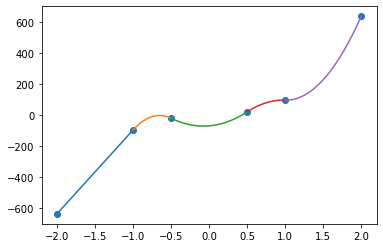

In [12]:
NM = NumMethods(Xs, Ys)
t = time()
NM.spline()
print(f'\nEl tiempo de ejecución fue de {time() - t} segundos.\n')
NM.Grafica()